# MapReduce-based CNN for Handwritten Digit Recognition

In [0]:
pip install keras

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install tensorflow

Python interpreter will be restarted.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-04439d8f-9ee8-4e14-a48d-7a89cc502673
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Not uninstalling protobuf at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-04439d8f-9ee8-4e14-a48d-7a89cc502673
    Can't uninstall 'protobuf'. No files were found to uninstall.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-04439d8f-9ee8-4e14-a48d-7a89cc502673
    Can't uninstall 'numpy'. No files we

# Importing required libraries

In [0]:
import random
import matplotlib.pyplot as pyplt
import numpy as np
from math import ceil

# Load MNIST Dataset

In [0]:
from keras import utils
from keras.datasets import mnist

# load the MNIST dataset
(train_images, train_labls), (test_images, test_labls) = mnist.load_data()

# reshape the training data of 60000 samples into 28x28
train_images = train_images.reshape(train_images.shape[0], 1, 28*28)
# Convert to float32 and normalize
train_images = train_images.astype('float32')
train_images /= 255
# one-hot encoding of truth label to an array of shape (1,9)
train_labls = utils.to_categorical(train_labls)

# similar processing for 10000 samples of test data
test_images = test_images.reshape(test_images.shape[0], 1, 28*28)
test_images = test_images.astype('float32')
test_images /= 255
test_labls = utils.to_categorical(test_labls)

/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


11490434/11490434 [==============================] - 1s 0us/step


In [0]:
# Convert to RDD
train_images_RDD = sc.parallelize(train_images.reshape(len(train_images),784).tolist(), 1)
train_labels_RDD = sc.parallelize(train_labls.tolist(), 1)
test_images_RDD = sc.parallelize(test_images.reshape(len(test_images),784).tolist(), 1)
test_labels_RDD = sc.parallelize(test_labls.tolist(), 1)

In [0]:
# Assign indices to labels to perform join
img_train = train_images_RDD.map(lambda e : np.array(e).reshape(28, 28)).zipWithIndex().map(lambda e: (str(e[1]), e[0]))

label_train = train_labels_RDD.map(lambda e : np.array(e).reshape(1, 10)).zipWithIndex().map(lambda e: (str(e[1]), e[0]))

img_test = test_images_RDD.map(lambda e : np.array(e).reshape(28, 28)).zipWithIndex().map(lambda e: (str(e[1]), e[0]))

label_test = test_labels_RDD.map(lambda e : np.array(e).reshape(1, 10)).zipWithIndex().map(lambda e: (str(e[1]), e[0]))

In [0]:
# Perform join to combine images with their encoded labels
training_set_rdd = img_train.join(label_train).map(lambda e: e[1]).map(lambda e: (e[0], np.array([e[1][0]])))
testing_set_rdd = img_test.join(label_test).map(lambda e: e[1]).map(lambda e: (e[0], np.array([e[1][0]])))

training_set_rdd.cache()

print("Training set count:", training_set_rdd.count())
print("Testing set count:", testing_set_rdd.count())

Training set count: 60000
Testing set count: 10000


# Function Definitions

## Convolutional Layer

In [0]:
# Forward Pass
def conv(img, fil, stride):
    new_img = [[] for _ in range(fil.shape[0])] 
    # horizontal slide
    for i in range(0, img.shape[0]-fil.shape[1]+1, stride):
        # vertical slide
        for j in range(0, img.shape[1]-fil.shape[2]+1, stride):
            tmp = img[i:i+fil.shape[1],j:j+fil.shape[2]]
            s = 0
            for k in range(fil.shape[0]):
                new_img[k].append(np.dot(tmp,fil[k]).sum())
    colvolved_imgs = [np.array(img1).reshape(ceil((img.shape[0] - fil.shape[1] + 1)/stride),ceil((img.shape[0] - fil.shape[1] + 1)/stride)) for img1 in new_img]
    return np.array(colvolved_imgs)

# Backward propagation
def inverse_conv(origImg, reluInv, gradMasks, filShape):
    grad_fil = np.empty((filShape[0],filShape[1],filShape[2]))
    sumT = 0
    for k in range(filShape[0]):
        for i in range(filShape[1]):
            for j in range(filShape[2]):
                grad_fil[k,i,j]= np.sum((gradMasks[k,:,:]*reluInv[k,:,:]) * origImg[i:i+reluInv.shape[1], j:j+reluInv.shape[2]])
    return grad_fil

## Activation Layer

In [0]:
# Forward Pass
def reLu(imgPixels):
    return np.maximum(0,imgPixels)


# Backward propagation
def inverse_relu(activation1):
    updated = np.maximum(0, activation1)
    updated[updated > 0] = 1
    return updated

## Max Pooling Layer

In [0]:
# Forward pass
def maxPool(images, fil, stride):
    pooled = [[] for _ in range(images.shape[0])] 
    poolLocs = [[] for _ in range(images.shape[0])]
    # For each convolution feature of image
    for k in range(images.shape[0]):
        # horizontal slide
        for i in range(0,images[k].shape[0]-fil.shape[0]+1, stride):
            # vertical slide
            for j in range(0,images[k].shape[1]-fil.shape[1]+1, stride):
                imgSlice = images[k][i:i+fil.shape[0],j:j+fil.shape[0]]
                maxLoc = np.where(imgSlice == np.amax(imgSlice, axis=(0,1)))
                maxloc = (maxLoc[0][0] + i, maxLoc[1][0] + j)
                maxVal = images[k][maxloc[0]][maxloc[1]]
                pooled[k].append(maxVal)
                poolLocs[k].append(maxloc)
        pooled[k] = np.array(pooled[k]).reshape(ceil((images[k].shape[0] - fil.shape[0] + 1)/stride), ceil((images[k].shape[1] - fil.shape[1] + 1)/stride))
        poolLocs[k] = np.array(poolLocs[k]).reshape(ceil((images[k].shape[0] - fil.shape[0] + 1)/stride), ceil((images[k].shape[1] - fil.shape[1] + 1)/stride), 2)
    return [np.array(poolLocs), np.array(pooled)]

# Backward propagation
def inverse_pooling(size, gradPool, maxPoolLocs):
    updatedMask = np.zeros(size)
    print(gradPool.shape)
    for maskIdx in range(size[0]):
        # gradients = gradPool[maskIdx]
        # locs = maxPoolLocs[maskIdx]
        for i in range(gradPool.shape[1]):
            for j in range(gradPool.shape[2]):
                updatedMask[maskIdx][maxPoolLocs[maskIdx][i][j][0]][maxPoolLocs[maskIdx][i][j][1]] = gradPool[maskIdx][i][j]
    return updatedMask

## Flatten Layer

In [0]:
#2D to 1D Forward Pass
def flatten(imgs):
    images = imgs.reshape(imgs.shape[0] * imgs.shape[1] * imgs.shape[2], 1)
    return images

#1D to 2D Backward Pass
def inverse_flatten(weights,softMaxDer,filters,rows,cols):
    flattenedImg = np.dot(weights, softMaxDer.T)
    return flattenedImg.reshape(filters, rows,cols)

## Fully Connected Layer

In [0]:
# Forward Pass
def fullyConnected(image, wgt, bias):
    fullyConnectedImg = np.dot(wgt.T, image) + bias 
    return fullyConnectedImg

# Backward Propagation
# Calculating d(E)/d(W) , where E is CrossEntropyLoss and W is the weight in W.X + B, and inputToFc is X.
def derWrtW1(inputToFC, softMaxDer):
    return np.dot(inputToFC, softMaxDer)

## SoftMax Layer

In [0]:
# Forward Pass
def softMax(prediction):
    normPred = np.exp(prediction - np.max(prediction))
    sumNormPred = sum(normPred)
    return np.array([pred / sumNormPred for pred in normPred]).reshape(1,10)

# Backward Propagation
# Calculating d(E)/d(Z) , where E is CrossEntropyLoss and Z in input to softmax layer, i.e W.X + B
def derSoftMax(prediction, trueClass):
    return prediction - trueClass

## Error Computation

In [0]:
# Cross Entropy Error Calculation
def crossEntropyError(prediction, trueClass):
    prediction = np.clip(prediction, 1e-7, 1 - 1e-7)
    return -np.sum(trueClass * np.log(prediction))

# Model Training

In [0]:
# Parameters initialization

# Kernels for convolution
fil=np.random.uniform(size=(3,5,5))

# MaxPooling window and stride
maxPoolFilter = np.zeros((2,2))
strideValue = 2

# Dense layer Weights and Bias
fc1Neurons = 10
orgShape = training_set_rdd.take(1)[0][0].shape
fc1WeightVector = np.random.rand(fil.shape[0] * ceil((orgShape[0] - fil.shape[1])/strideValue) * ceil((orgShape[1] - fil.shape[2])/strideValue), fc1Neurons) - 0.5
fc1BiasVector = np.random.rand(fc1Neurons, 1) - 0.5

# Learning Rate
lr = 0.0125

# Number of iterations
n_iters = 100

# Data for training cost and accuracy curves 
loss_curve = []
acc_curve = []


# Training begins
for i in range(n_iters):
    # Forward Propagation
    convolution1 = training_set_rdd.sample(False,0.01).map(lambda e : (e[0], conv(e[0], fil, 1), e[1]))
    activation1 = convolution1.map(lambda e: (e[0], e[1], reLu(e[1]), e[2]))
    maxPooling1 = activation1.map(lambda e: (e[0], e[1], e[2], maxPool(e[2], maxPoolFilter, strideValue), e[3]))
    flattened1 = maxPooling1.map(lambda e: (e[0], e[1], e[2], e[3], flatten(e[3][1]), e[4]))
    fullyConnected1 = flattened1.map(lambda e:(e[0], e[1], e[2], e[3], e[4], fullyConnected(e[4], fc1WeightVector, fc1BiasVector), e[5]))
    normalized = fullyConnected1.map(lambda e: (e[0], e[1], e[2], e[3], e[4], e[5], softMax(e[5]), e[6]))

    # Backward Propagation 
    errAndSoftMaxDer = normalized.map(lambda e: (e[0], e[1], e[2], e[3], e[4], e[5], e[6], crossEntropyError(e[6], e[7]), derSoftMax(e[6], e[7]), e[7], int(np.argmax(e[6]) == np.argmax(e[7]))))
    derB1andW1 = errAndSoftMaxDer.map(lambda e: (e[0], e[1], e[2], e[3], e[4], e[5], e[6], e[7], e[8], e[8], derWrtW1(e[4], e[8]), e[9], e[10]))
    flattenedInv = derB1andW1.map(lambda e: (e[0], e[1], e[2], e[3], e[4], e[5], e[6], e[7], e[8], e[9], e[10], inverse_flatten(fc1WeightVector, e[8], e[3][1].shape[0], e[3][1].shape[1], e[3][1].shape[2]), e[11], e[12]))
    pooledInv = flattenedInv.map(lambda e: (e[0], e[1], e[2], e[3], e[4], e[5], e[6], e[7], e[8], e[9], e[10], e[11], inverse_pooling(e[2].shape, e[11], e[3][0]), e[12], e[13]))
    activationInv = pooledInv.map(lambda e: (e[0], e[1], e[2], e[3], e[4], e[5], e[6], e[7], e[8], e[9], e[10], e[11], e[12], inverse_relu(e[2]),e[13], e[14]))
    convInverse = activationInv.map(lambda e:(e[0], e[1], e[2], e[3], e[4], e[5], e[6], e[7], e[8], e[9], e[10], e[11], e[12], e[13], inverse_conv(e[0], e[13], e[12], fil.shape), e[14], e[15], 1))
    # End of backpropagation
    # Filtering only error, bias, weights, kernels from rdd
    learningRDD = convInverse.map(lambda e: (e[7], e[9], e[10], e[14], e[16], e[17]))
    # Performing reduce to compute mean values
    finalRDD = learningRDD.reduce(lambda e1, e2: (e1[0]+e2[0], e1[1]+e2[1], e1[2]+e2[2], e1[3]+e2[3], e1[4]+e2[4], e1[5]+e2[5]))

    numRows = finalRDD[-1]
    avgLoss = finalRDD[0]/numRows
    avgBiasGrad = finalRDD[1]/numRows
    avgWeightGrad = finalRDD[2]/numRows
    avgFiltersGrad = finalRDD[3]/numRows
    avgAcc = finalRDD[4]/numRows

    # Applying gradient descent
    if avgAcc >= 83:
        lr = 0.00125
    fc1WeightVector -= lr*avgWeightGrad
    fc1BiasVector -= lr*avgBiasGrad.T
    fil -= lr*avgFiltersGrad

    # Appending this iteration's outputs
    loss_curve.append(avgLoss)
    acc_curve.append(avgAcc)

    print(f"   Iteration {i+1}/{n_iters} | Error: {avgLoss} | Acc: {avgAcc*100} | Batch_size:{numRows}")
print("############################")
print("TRAINING COMPLETED")

   Iteration 1/100 | Error: 14.253411091866568 | Acc: 10.033444816053512 | Batch_size:598
   Iteration 2/100 | Error: 12.466309572001647 | Acc: 21.04404567699837 | Batch_size:613
   Iteration 3/100 | Error: 13.100626908105573 | Acc: 17.142857142857142 | Batch_size:630
   Iteration 4/100 | Error: 11.992188760626147 | Acc: 21.525423728813557 | Batch_size:590
   Iteration 5/100 | Error: 10.76764406287357 | Acc: 31.606217616580313 | Batch_size:579
   Iteration 6/100 | Error: 11.489954782091477 | Acc: 26.70906200317965 | Batch_size:629
   Iteration 7/100 | Error: 11.064415182810961 | Acc: 29.01023890784983 | Batch_size:586
   Iteration 8/100 | Error: 9.462346776574277 | Acc: 39.93453355155483 | Batch_size:611
   Iteration 9/100 | Error: 9.709843750092611 | Acc: 37.185929648241206 | Batch_size:597
   Iteration 10/100 | Error: 10.547708326550103 | Acc: 31.67808219178082 | Batch_size:584
   Iteration 11/100 | Error: 7.898301814605066 | Acc: 49.01639344262295 | Batch_size:610
   Iteration 12/10

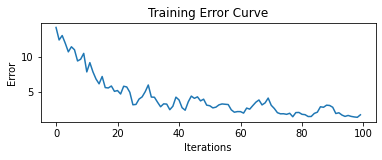

In [0]:
# Cost curve over iterations
pyplt.subplot(2, 1, 1)
pyplt.plot(loss_curve)
pyplt.xlabel('Iterations') 
pyplt.ylabel('Error') 
pyplt.title("Training Error Curve")
pyplt.show()

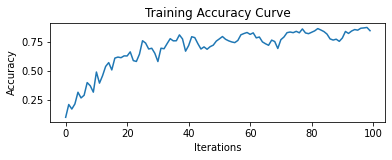

In [0]:
# Accuracy curve over iterations
pyplt.subplot(2, 1, 2)
pyplt.plot(acc_curve)
pyplt.xlabel('Iterations') 
pyplt.ylabel('Accuracy') 
pyplt.title("Training Accuracy Curve")
pyplt.show()

# Testing Phase

In [0]:
# Test RDD going through forward pass with updated weights 
convolutionTest = testing_set_rdd.map(lambda e : (e[0], conv(e[0], fil, 1), e[1]))
activationTest = convolutionTest.map(lambda e: (e[0], e[1], reLu(e[1]), e[2]))
maxPoolingTest = activationTest.map(lambda e: (e[0], e[1], e[2], maxPool(e[2], maxPoolFilter, strideValue), e[3]))
flattenedTest = maxPoolingTest.map(lambda e: (e[0], e[1], e[2], e[3], flatten(e[3][1]), e[4]))
fullyConnectedTest = flattenedTest.map(lambda e:(e[0], e[1], e[2], e[3], e[4], fullyConnected(e[4], fc1WeightVector, fc1BiasVector), e[5]))
ouputTest = fullyConnectedTest.map(lambda e: (e[0], e[1], e[2], e[3], e[4], e[5], softMax(e[5]), e[6]))
# Final MapReduce operation to compute number of accurate predictions on test data
accuracyRDDTest = ouputTest.map(lambda e: (int(np.argmax(e[6]) == np.argmax(e[7])), 1))
finalTest = accuracyRDDTest.reduce(lambda e1, e2: (e1[0]+e2[0], e1[1]+e2[1]))

# Accuracy computation over testing data (number of accurate prediction/total data size)
nTest = finalTest[-1]
nAccuracy = finalTest[0]/nTest

In [0]:
# Displaying test data accuracy
print(f"Testing Set Accuracy: {nAccuracy*100}")

Testing Set Accuracy: 84.11
